In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

In [6]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
gb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [9]:
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting Mean Squared Error: {mse_gb}')
print(f'Gradient Boosting Root Mean Squared Error: {rmse_gb}')
print(f'Gradient Boosting R-squared: {r2_gb}')

Gradient Boosting Mean Squared Error: 18732863.283815846
Gradient Boosting Root Mean Squared Error: 4328.147789045083
Gradient Boosting R-squared: 0.8793364486536337


In [10]:
feature_importances_gb = gb_model.named_steps['regressor'].feature_importances_
features = numeric_features + list(gb_model.named_steps['preprocessor'].named_transformers_['cat']
                                   .named_steps['onehot'].get_feature_names_out(categorical_features))
importance_df_gb = pd.DataFrame({'Feature': features, 'Importance': feature_importances_gb}).sort_values(by='Importance', ascending=False)

In [11]:
param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 4]
}
grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)
print(f'Best parameters (Gradient Boosting): {grid_search_gb.best_params_}')
print(f'Best cross-validation score (MSE, Gradient Boosting): {-grid_search_gb.best_score_}')

Best parameters (Gradient Boosting): {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Best cross-validation score (MSE, Gradient Boosting): 21585994.512234174


In [12]:
best_gb_model = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
best_mse_gb = mean_squared_error(y_test, y_pred_best_gb)
best_rmse_gb = np.sqrt(best_mse_gb)
best_r2_gb = r2_score(y_test, y_pred_best_gb)
print(f'Best Gradient Boosting Mean Squared Error: {best_mse_gb}')
print(f'Best Gradient Boosting Root Mean Squared Error: {best_rmse_gb}')
print(f'Best Gradient Boosting R-squared: {best_r2_gb}')

Best Gradient Boosting Mean Squared Error: 18516292.191308457
Best Gradient Boosting Root Mean Squared Error: 4303.056145498041
Best Gradient Boosting R-squared: 0.8807314429342721


In [13]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [14]:
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest Root Mean Squared Error: {rmse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

Random Forest Mean Squared Error: 21003637.60876614
Random Forest Root Mean Squared Error: 4582.9725734250405
Random Forest R-squared: 0.8647097634425496


In [15]:
feature_importances_rf = rf_model.named_steps['regressor'].feature_importances_
importance_df_rf = pd.DataFrame({'Feature': features, 'Importance': feature_importances_rf}).sort_values(by='Importance', ascending=False)

In [16]:
def clean_array(data):
    return data[np.isfinite(data)]

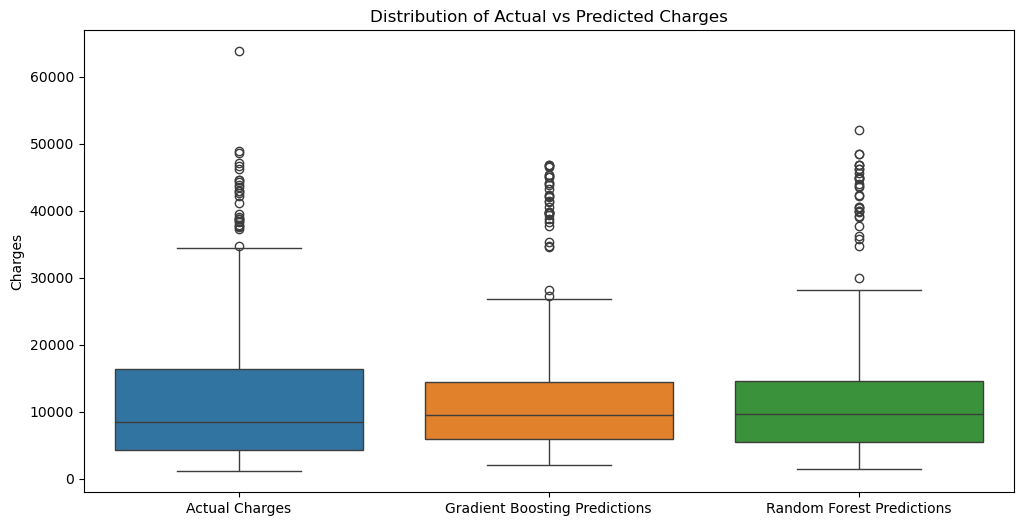

In [17]:
plt.figure(figsize=(12, 6))

data_combined = pd.DataFrame({
    'Actual Charges': y_test,
    'Gradient Boosting Predictions': y_pred_best_gb,
    'Random Forest Predictions': y_pred_rf
})

sns.boxplot(data=data_combined)
plt.ylabel('Charges')
plt.title('Distribution of Actual vs Predicted Charges')
plt.show()

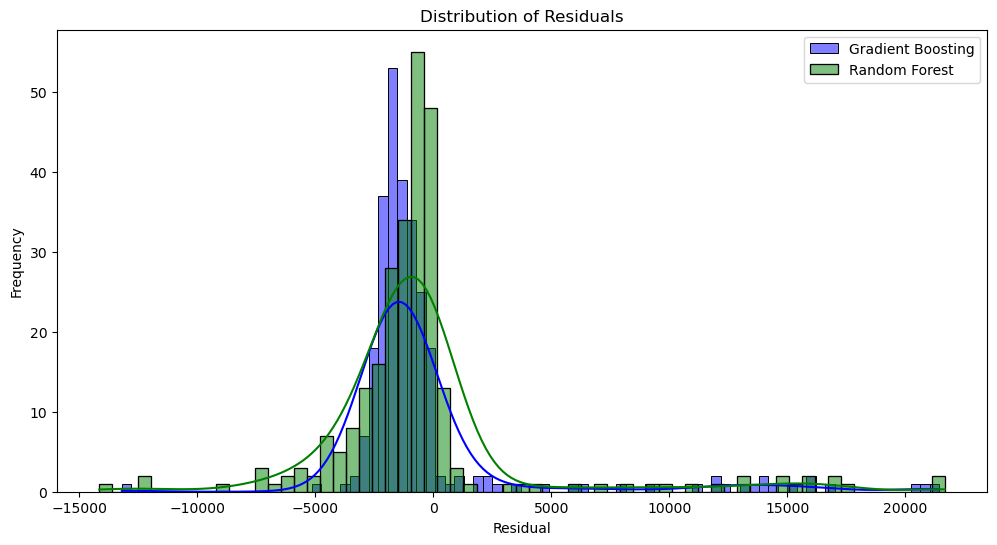

In [18]:
residuals_gb = y_test - y_pred_best_gb
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(12, 6))
sns.histplot(clean_array(residuals_gb), kde=True, color='blue', label='Gradient Boosting')
sns.histplot(clean_array(residuals_rf), kde=True, color='green', label='Random Forest')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.legend()
plt.show()

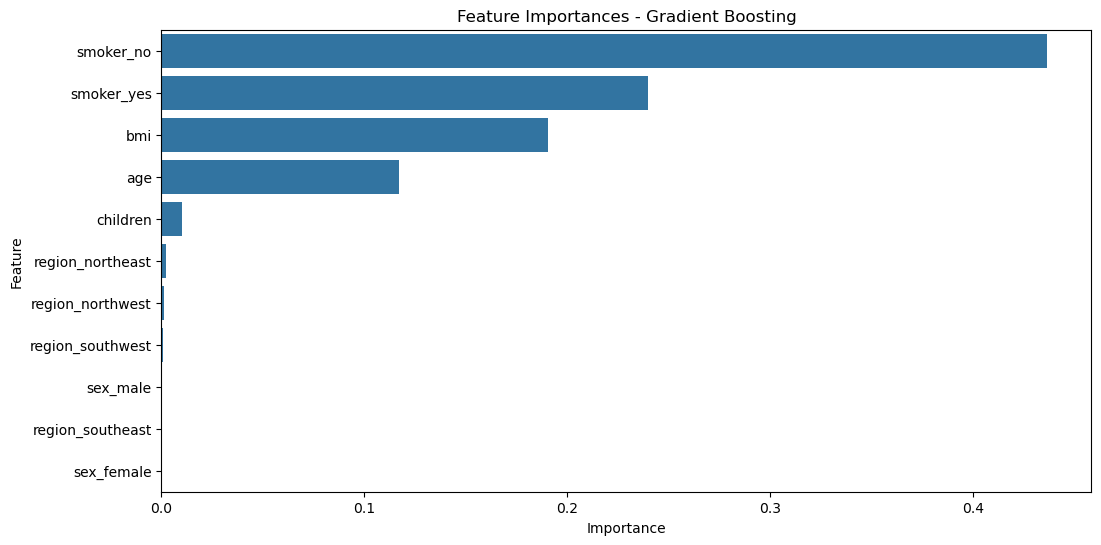

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_gb)
plt.title('Feature Importances - Gradient Boosting')
plt.show()

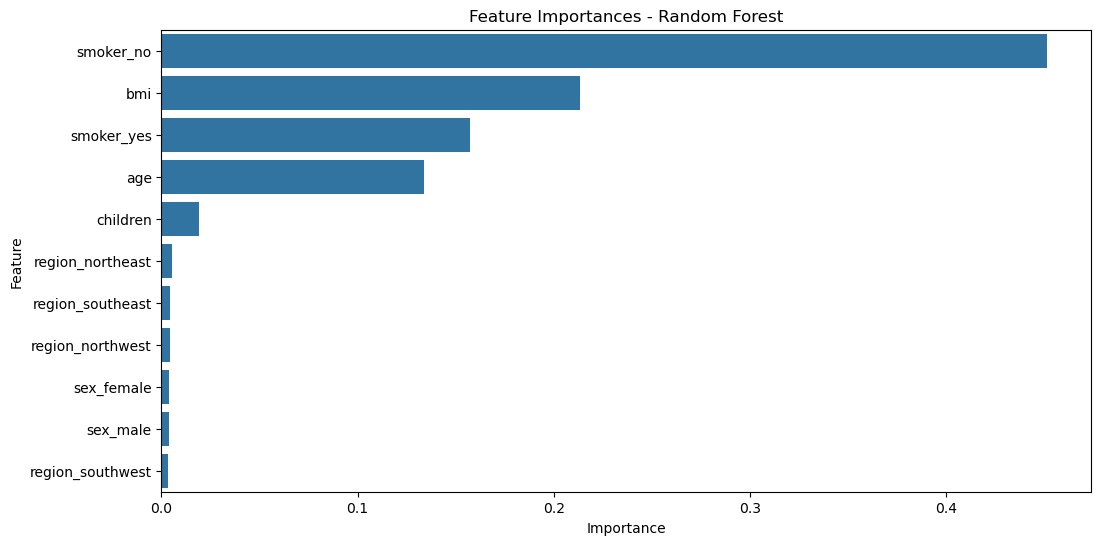

In [20]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importances - Random Forest')
plt.show()

In [21]:
def check_bias(data, predictions, group):
    bias_df = pd.DataFrame({'Actual': data, 'Predicted': predictions, 'Group': group})
    return bias_df.groupby('Group').mean()

In [22]:
bias_gb = check_bias(y_test, y_pred_best_gb, X_test['smoker'])
print("Bias check for Gradient Boosting:")
print(bias_gb)

Bias check for Gradient Boosting:
             Actual     Predicted
Group                            
no      7862.090201   8208.323794
yes    33204.104995  33102.288528


In [23]:
bias_rf = check_bias(y_test, y_pred_rf, X_test['smoker'])
print("Bias check for Random Forest:")
print(bias_rf)

Bias check for Random Forest:
             Actual     Predicted
Group                            
no      7862.090201   8243.513803
yes    33204.104995  33880.005629
